# Gangs Matrix - Shuffle Analysis

*Toby Davies*

This notebook outlines an attempt to examine data concerned with the London 'Gangs Matrix' in order to explore whether inclusion on the Matrix is associated with changes in offending behaviour. 

The key challenge here is the absence of a counterfactual (i.e. a control group), which means that the expected level of offending in the absence of treatment cannot be directly estimated. In particular, interpretation of pre- and post-intervention offending rates is not straightforward because of the 'age-crime curve' - even in the absence of an intervention, offending would be expected to peak at approximately the age that individuals are typically added to the matrix, which means that decreases in victimisation cannot necessarily be attributed to the intervention.

This analysis seeks to overcome this challenge by generating an estimate of the expected offending rate in the absence of intervention. It does this by using a permutation-based approach, in which entry points to the matrix are randomly re-assigned and offending rates re-computed. The principle is that this should reflect the anticipated evolution of offending rates given the observed distributions of offending and matrix entry, but assuming that there is no association between the two.

## Data loading and preparation

Some initial package imports to work with the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

Set up some plotting parameters.

In [2]:
sns.set_theme(style='whitegrid', font='Bahnschrift', font_scale=1.2)
sns.set_style({"grid.color": ".8"})

Read the base data file in order to access within Python - print first 2 rows to check validity.

In [3]:
# Use the URN as the index
# Sheet name selects Excel sheet - 0 for raw counts, 1 for binary alternative
data = pd.read_excel("A:/UCLMaster_V2.xlsx", sheet_name=1, index_col='URN')
data.head(2)

,END,FirstOn-1,LastOn+1,AgeOnMatrix,PreMths,DuringMths,PostMths,Pre48,Pre47,Pre46,...,Post39,Post40,Post41,Post42,Post43,Post44,Post45,Post46,Post47,Post48
URN,,,,,,,,,,,,,,,,,,,,,
1,2017-10-31,2015-05-01,2016-04-01,28,221,11,19.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10-31,2013-07-01,2018-03-01,27,209,52,NaN,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data loaded successfully.

## Replicating the basic MOPAC graph

As an initial check of the data, attempt to replicate the graph derived during previous MOPAC analysis, which shows a noticeable rise and fall in offending either side of matrix entry. This graph shows the *proportion* of matrix members who offended in each month before, during and after their matrix entry.

These proportions should be given by the means of the corresponding `PreXX/DurXX/PostXX` columns, since these should be the proportions with entry 1. So calculate those and plot:

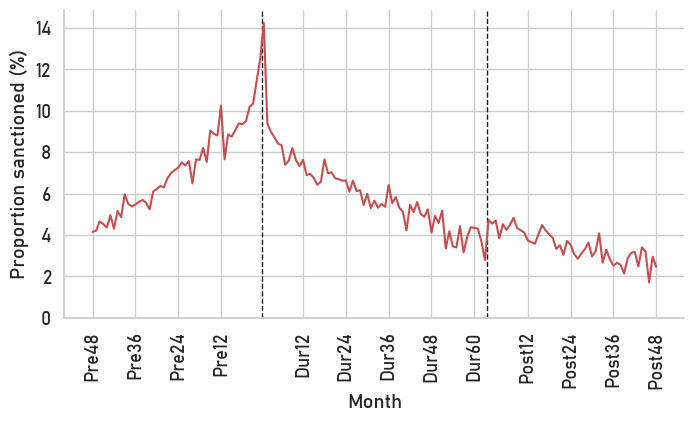

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

# Calculate means for each of the relevant columns and plot
proportions = data.loc[:, 'Pre48':'Post48'].mean() * 100
proportions.plot(ylim=0, rot=90, c='r', ax=ax)

# Fix the axis labels
xpoints = list(range(0,48,12)) + list(range(59,112,12)) + list(range(122,159,12))
plt.xticks(xpoints, proportions.index[xpoints], zorder=2)
plt.xlabel('Month')
plt.ylabel('Proportion sanctioned (%)')

# Plot aesthetics
sns.despine()

# Add some lines to show entry and exit points
plt.axvline(47.5, color ='k', ls='--', lw=1, zorder=1)
plt.axvline(110.5, color ='k', ls='--', lw=1, zorder=1);

This looks broadly in line with expectation (i.e. what was shown in previous analysis) - sanction rate builds in the period prior to Matrix entry, then falls afterwards. However, as noted above, this could simply be an artefact of the age-crime curve. So we move on to our proposed approach.

## Restructuring data

For this analysis, it is going to be useful to have a continuous month-by-month 'history' for each individual, agnostic to the particular 'landmark' points in the data (i.e. Matrix entry and exit). The raw data is not structured in this way, because it has a set number of columns for each 'stage', not all of which might be filled. For example, if an individual was only on the matrix for 2 months, then `Dur3` will be missing, and the next valid value will be `Post1`.

So for this analysis we will restructure in order to have a full continuous history for each individual, indexed according to their age (in months). From this, we can then always recover the data for any month because we know when the data started, how many months the individuals was on the Matrix, etc.

First of all, for housekeeping, count the number of non-missing months at each stage, for each individual.

In [5]:
# Count how many valid values for each time period
data['ValidPre'] = data.loc[:,'Pre48':'Pre1'].count(axis=1)
data['ValidDur'] = data.loc[:,'Dur1':'Dur63'].count(axis=1)
data['ValidPost'] = data.loc[:,'Post1':'Post48'].count(axis=1)
data['ValidAll'] = data.loc[:,'Pre48':'Post48'].count(axis=1)

# Sanity check that the sums line up
(data['ValidAll'] == data['ValidPre'] + data['ValidDur'] + data['ValidPost']).all()

np.True_

Another small change. The variable `PostMths` (the number of months the individual was observed after exiting the Matrix) is missing if the individual was still on the Matrix at census point - fill this with 0s.

In [6]:
# Fill missing values of PostMths with zeros
data['PostMths'] = data['PostMths'].fillna(0)

Record the month at which they were last recorded on Matrix (for those who have left the Matrix, this is their departure month).

In [7]:
data['PreDurMths'] = data['PreMths'] + data['DuringMths']

Now we will also make a record for each case of the start point of their known history - that is, the month from which their criminal history is present in the data (measured as *months since 10th birthday*). This is going to be the month in which they entered the matrix (recorded in the data as `PreMths`), minus the number of valid `PreXX` months available.

In [8]:
# Note the first valid month in the data, measured from 10th birthday
# Month columns are measured SINCE this - first valid PreXX is 0 months after StartMth
data['StartMth'] = data['PreMths'] - data['ValidPre']

# EndMth will be one after the last valid month in the data (i.e. the next missing month)
data['EndMth'] = data['StartMth'] + data['ValidAll']

Now we will do some reshaping of the data to get individual histories as columns. First slice only the sanction columns, then transpose the data so that rows are time points and columns are individuals.

In [9]:
histories_raw = data.loc[:, 'Pre48': 'Post48'].T
histories_raw.shape

(159, 7129)

This makes sense - we have at most 159 months' of data for each individual, and there are 7129 individuals.

In [10]:
histories_raw.head(2)

URN,1,2,3,4,5,6,7,8,9,10,...,7290,7291,7292,7293,7294,7295,7296,7297,7298,7299
Pre48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Pre47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Just as with the original data, this will have gaps (for example, if an individual was only on the matrix for 2 months, then `Dur3` will be missing, and the next valid value will be `Post1`). This means there will be gaps in the columns.

Now reshape the histories to remove these gaps, so that each column is a continuous month-by-month history for each individual. Set the row index so that it corresponds to the number of months since 10th birthday - so now the columns are aligned according to age.

In [11]:
# Set up a dictionary to record each individual's history
histories_continuous = {}
for urn in histories_raw:
    #For each column, drop missing values
    history = histories_raw[urn].dropna()
    #Re-set the index so it corresponds to the individual's age
    history.index = np.arange(data.loc[urn,'StartMth'], data.loc[urn,'EndMth'])
    histories_continuous[urn] = history
# Store these histories as a DataFrame
histories = pd.DataFrame(histories_continuous)
histories.shape

(583, 7129)

This reshaped dataset has 583 rows - this must be the maximum age at which any individual appears in the data.

Check that each column contains the correct number of non-missing entries.

In [12]:
(histories.count() == data['ValidAll']).all()

np.True_

Each individual's history should now appear in the relevant slice. Can see an example of this for one individual as follows.

In [13]:
# Get the position that should contain the last missing value
# This is the month before the first observation of this individual
index_last_missing = data.loc[1, 'StartMth'] - 1
# Equivalently get the index of the first unobserved month after the observation period
index_next_missing = data.loc[1, 'EndMth']
# View the offending history for this period
histories.loc[index_last_missing: index_next_missing, 1]

172    NaN
173    0.0
174    0.0
175    0.0
176    0.0
      ... 
247    0.0
248    0.0
249    0.0
250    0.0
251    NaN
Name: 1, Length: 80, dtype: float64

## Descriptive analysis

Before going any further, it's worth taking a look at the nature of the data. There are a few features here which are relevant to some of the later findings.

### Entry and exit points

The entry and exit points onto the matrix indicate not only the time periods for which data is available, but also the ages at which individuals tend to enter the matrix.

First we can check the entry points for the data as a whole.

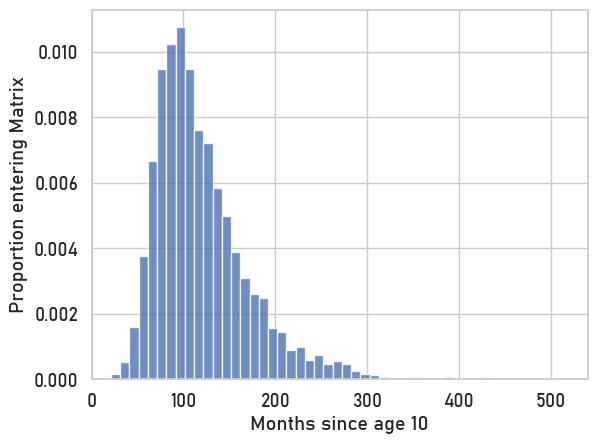

In [14]:
data['PreMths'].plot.hist(bins=50, alpha=0.8, density=True)
plt.xlabel('Months since age 10')
plt.ylabel('Proportion entering Matrix')
plt.xlim(0, 540);

Clearly there is a strong peak in the late teens (96 months corresponds to 18 years) and almost all cases entered prior to 200 months.

Restricting to only individuals who have actually exited, we can similarly check the distribution of exit points (exit points of people still on the matrix would be meaningless).

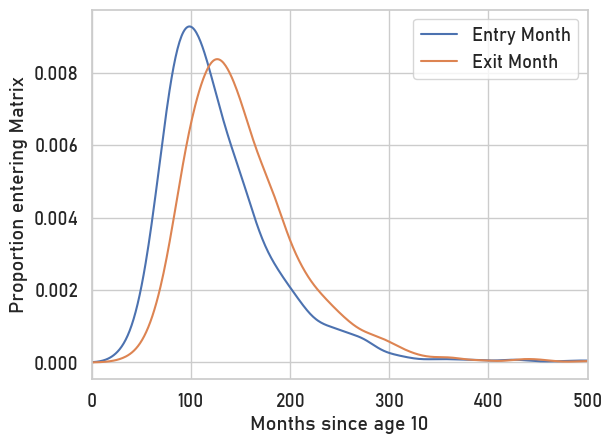

In [15]:
data[data['ValidPost'] > 0]['PreMths'].plot.kde(label='Entry Month')
data[data['ValidPost'] > 0]['PreDurMths'].plot.kde(label='Exit Month')
plt.legend()
plt.xlabel('Months since age 10')
plt.ylabel('Proportion entering Matrix')
plt.xlim(0, 500);

Again there is a clear peak in the data - individuals who have exited the Matrix typically exit in early 20s.

One final check we can do is the time spent on the Matrix, again restricted to those who have exited it. Again this is clearly a biased sample because it ignores those who remain on the Matrix - the most common duration in the unfiltered data is 63 months (people who were added at the start of the intervention and have never left).

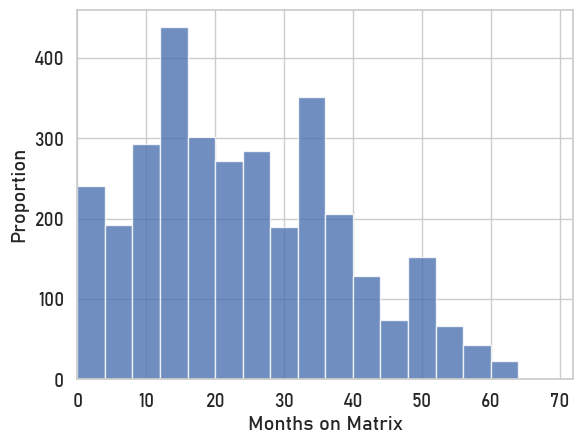

In [16]:
data[data['ValidPost'] > 0]['ValidDur'].plot.hist(bins=range(0, 72, 4), alpha=0.8)
plt.xlabel('Months on Matrix')
plt.ylabel('Proportion')
plt.xlim(0, 72);

A fairly even distribution in terms of duration on the Matrix.

### Age-crime curve

The available data also gives us the opportunity to examine the age-crime relationship within the data - that is, the offending rate for individuals in the data according to age. This is a key issue here because it affects the expected evolution of offending rates - if offending rates change over time, then they would be expected to change even in the absence of an intervention effect.

While we do not have full 'lifetime' histories for each individual, we have 'windows' into their lifetime offending. We have at most 48 months before they entered the Matrix, and at most 63 after, but precisely which months these are depends on the age at which they entered the Matrix. But by overlaying them we can get an idea of the behaviour of the cohort as a whole at different ages.

First of all, we can calculate how many data points we have for every age. That is, for each age (measured in *months-since-10th-birthday*) we can calculate the number of individuals for which we have data (i.e. who are 'observed' in the dataset at this age).

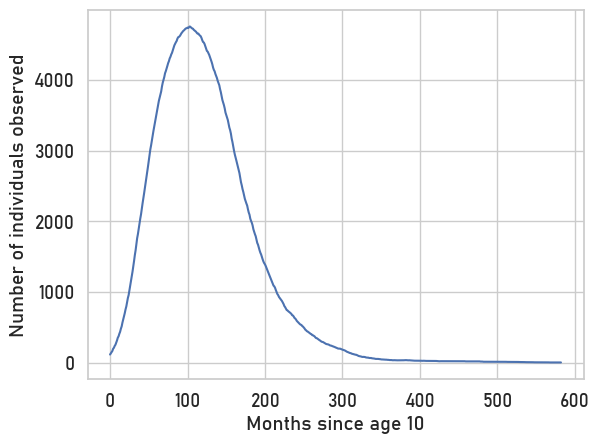

In [17]:
histories.count(axis=1).plot()
plt.xlabel('Months since age 10')
plt.ylabel('Number of individuals observed');

Similarly, we can count the number of individuals who committed a crime at this age (the number of columns containing a 1).

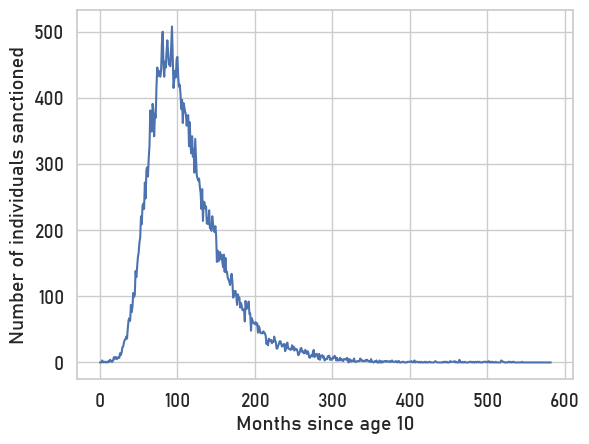

In [18]:
histories.sum(axis=1).plot()
plt.xlabel('Months since age 10')
plt.ylabel('Number of individuals sanctioned');

The mean of each row corresponds to the offending rate - it is equivalent to the proportion of (non-missing) values in that row that have value 1. This can be interpreted as the proportion of individuals in the data that are sanctioned at this age. *For any individual who is in the data in their Xth month of age, there is a Y% chance they will be sanctioned that month*.

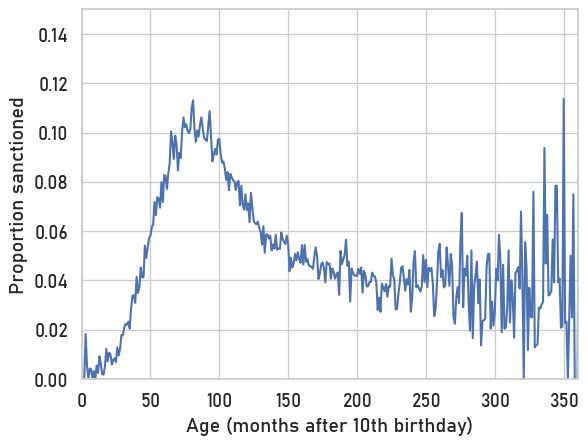

In [19]:
histories.mean(axis=1).plot()
plt.xlim(0,360)
plt.ylim(0, 0.15)
plt.xlabel('Age (months after 10th birthday)')
plt.ylabel('Proportion sanctioned')
plt.savefig('./plots/age_crime', dpi=300);

This resembles a classic age-crime curve. We see a gradual increase to a peak of offending in the late teens (in each month around this age, approximately 11% of individual are sanctioned), before a decline into the mid-20s. The graph becomes very noisy at higher ages, primarily because of the low number of individuals in the data at this point - this means the denominator is very small, so even small changes in the volume of offending cause large changes in rate.

By overlaying this with the distribution of entry points to the Matrix, we can see the challenge for analysis.

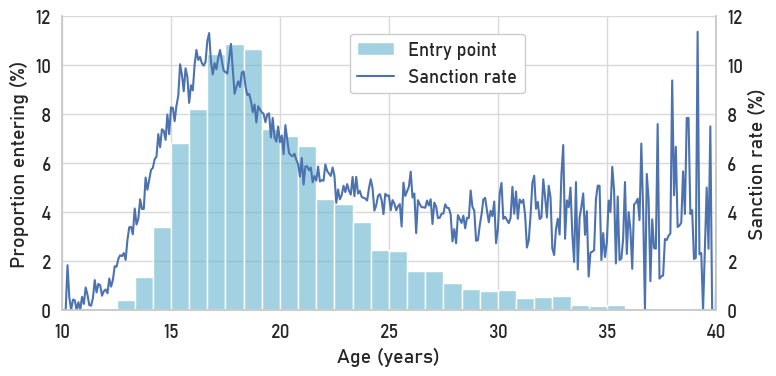

In [20]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Convert PreMths to version measured in years
# Original version measured in terms of months since 10th birthday
data['PreMths_Yrs'] = data['PreMths'] / 12 + 10
# Calculate sanction rate per month
rate_per_month = histories.mean(axis=1) * 100
# Reset the index of this sanction rate so it is measured in terms of years
rate_per_month.index = rate_per_month.index / 12 + 10

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))
# Plot histogram of entry points
hist_ax = sns.histplot(data['PreMths_Yrs'], binrange=[10,40], bins=36, stat='percent', color='c', alpha=0.6, ax=ax, label='Entry point')
# Plot sanction rate over time, scaled to secondary axis
rate_ax = rate_per_month.plot(zorder=1, label='Sanction rate', secondary_y=True, mark_right=False)
# Reset axis limits and labels
rate_ax.set_xlim(10, 40)
rate_ax.set_ylim(0, 12)
hist_ax.set_ylim(0, 12)
hist_ax.set_xlabel('Age (years)')
rate_ax.set_ylabel('Sanction rate (%)')
hist_ax.set_ylabel('Proportion entering (%)')

# Tick aesthetics
sns.despine(right=False)
hist_ax.tick_params(axis='y', length=0, pad=8)
rate_ax.tick_params(axis='y', length=0, pad=8)

# Tidy up figure and save
fig.legend(loc=(0.45,0.75), framealpha=1)
plt.tight_layout()
plt.savefig('./plots/age_crime_vs_entry_col.png', dpi=300);

Recreate this plot in grayscale.

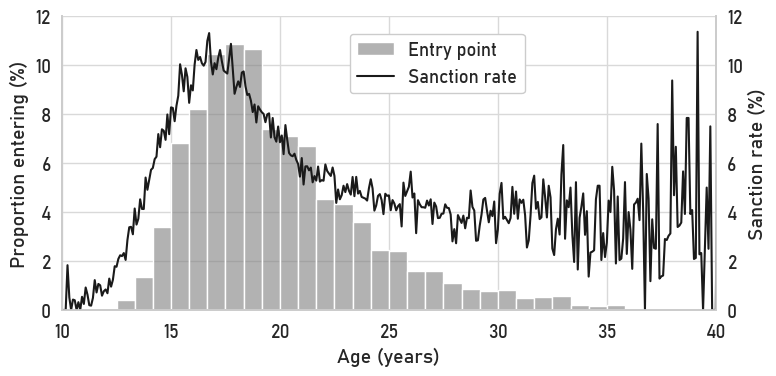

In [21]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Convert PreMths to version measured in years
# Original version measured in terms of months since 10th birthday
data['PreMths_Yrs'] = data['PreMths'] / 12 + 10
# Calculate sanction rate per month
rate_per_month = histories.mean(axis=1) * 100
# Reset the index of this sanction rate so it is measured in terms of years
rate_per_month.index = rate_per_month.index / 12 + 10

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))
# Plot histogram of entry points
hist_ax = sns.histplot(data['PreMths_Yrs'], binrange=[10,40], bins=36, stat='percent', color='0.5', alpha=0.6, ax=ax, label='Entry point')
# Plot sanction rate over time, scaled to secondary axis
rate_ax = rate_per_month.plot(zorder=1, label='Sanction rate', color='k', secondary_y=True, mark_right=False)
# Reset axis limits and labels
rate_ax.set_xlim(10, 40)
rate_ax.set_ylim(0, 12)
hist_ax.set_ylim(0, 12)
hist_ax.set_xlabel('Age (years)')
rate_ax.set_ylabel('Sanction rate (%)')
hist_ax.set_ylabel('Proportion entering (%)')

# Tick aesthetics
sns.despine(right=False)
hist_ax.tick_params(axis='y', length=0, pad=8)
rate_ax.tick_params(axis='y', length=0, pad=8)

# Tidy up figure and save
fig.legend(loc=(0.45,0.75), framealpha=1)
plt.tight_layout()
plt.savefig('./plots/age_crime_vs_entry_bw.png', dpi=300);

This illustrates the problem - the ages at which individuals are added to the Matrix align almost exactly with their peak of offending (of course, this is no coincidence). This means that, if one was to examine an individual before and after such an age, their offending rate would be expected to decrease anyway. So the challenge for analysis is to establish whether the observed decrease is greater than the expected one, or just consistent with it.

## Permutation analysis

With the restructured data (i.e. full histories), we now use a different approach to calculating offending rates with respect to any given reference point (e.g. point of entry to the matrix).

The idea is this:

- In current form, the histories are indexed according to age. So, for every individual, row **i** corresponds to their sanctions at age **i** (in terms of months since 10th birthday, as usual).
- If we want to know their offending rates before/after intervention, shift the data up or down according to their month of entry to the matrix. So if an individual entered in month **j**, shift their data up by **j** rows. Now row 0 corresponds to the month they entered the Matrix, row 1 is the first month after, etc
- After all individuals have been aligned in this way, the average of each row gives the proportion of individuals who offended in this month *relative to matrix entry*

To do this, we need to write a couple of functions.

The first function will realign the data according to a prescribed shift on each column. Whatever shift is specified for each column, the data will be shifted **up** by that number of places - so for example if individual X is specified value Y, the data for the Yth month will appear at index 0 in the result.

As per the above, the use-case for this is to re-align every column according to the age at matrix entry, so that index 0 corresponds to every individual's month of entry.

In [22]:
def align_data(histories, shifts):
    # Approach is based on 'rolling' each column upwards
    # This means that the values that get shifted off the top reappear at the bottom
    # Thanks to https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently/20361561#20361561
    # Get open meshgrid containing row and column indices
    rows, cols = np.ogrid[:histories.shape[0], :histories.shape[1]]
    # Use broadcasting logic to get different shifts of the row indices on each column
    # Basically creates multiple copies of the row indices, subtracting different amount each time
    row_indices = rows - (histories.shape[0] - shifts.values)
    # Get aligned histories by using these indices to slice the original values
    aligned_histories = histories.values[row_indices, cols]
    return aligned_histories

When we do this, we want to retain some rows corresponding to months **before** the intervention, and some rows representing months **after** (so that we can do pre/post analysis). To do this, we need to add some rows for negative values first, representing the maximum number of months we want to examine retrospectively.

Write a function which performs this buffering, aligns the data according to prescribed shifts, then returns result.

In [23]:
def align_data_buff(histories, shifts, pre_steps, post_steps):
    # Realign the data by 'rolling' columns upwards
    hist = align_data(histories, shifts)
    # The 'pre' period now appears at the bottom of the array, so slice this
    pre_data = hist[-pre_steps:,:]
    # The 'post' steps are at the top of the array, so slice these
    post_data = hist[:post_steps,:]
    # Stack these vertically
    hist = np.vstack((pre_data, post_data))
    # Return the resulting DataFrame with row indices set accordingly
    return pd.DataFrame(hist, columns=histories.columns, index=np.arange(-pre_steps, post_steps))

We can use this to look at the sanction rates in each month before and after intervention.

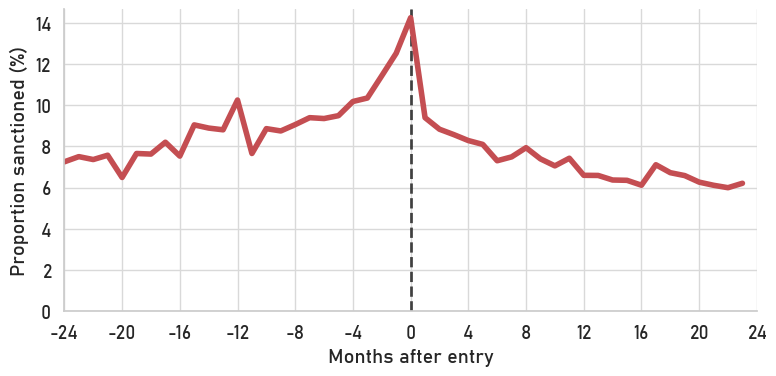

In [24]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Align the histories according to 'PreMths'
# This means all columns are aligned with respect to Matrix entry point
histories_aligned = align_data_buff(histories, data['PreMths'], 24, 24)
#Calculate the means for each row, scaled as percentages
observed_rates = histories_aligned.mean(axis=1) * 100

#Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot sanction rates by month
observed_rates.plot(ylim=(0), color='r', lw=4, ax=ax)
# Add a reference line at entry point
ax.axvline(0, color ='k', ls='--', lw=2, alpha=0.8, zorder=1)

# Adjust limits and labels
ax.set_xlim(-24,24)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned (%)')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/sanction_rate_pre_post_entry_col.png', dpi=300);

Grayscale version.

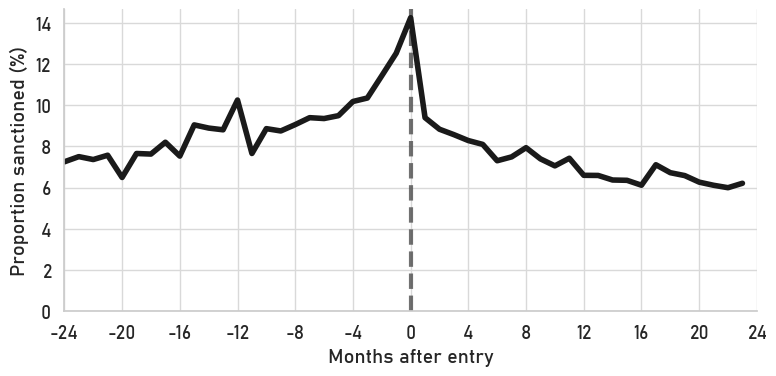

In [25]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Align the histories according to 'PreMths'
# This means all columns are aligned with respect to Matrix entry point
histories_aligned = align_data_buff(histories, data['PreMths'], 24, 24)
#Calculate the means for each row, scaled as percentages
observed_rates = histories_aligned.mean(axis=1) * 100

#Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot sanction rates by month
observed_rates.plot(ylim=(0), color='k', lw=4, ax=ax)
# Add a reference line at entry point
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Adjust limits and labels
ax.set_xlim(-24,24)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned (%)')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/sanction_rate_pre_post_entry_bw.png', dpi=300);

We see the same pattern that we saw before: a clear peak around the point of entry, followed by a decrease afterwards. To restate, the analytical challenge is to establish whether this decrease is greater than would be expected if there was no association.

To do this, we use a permutation approach. The principle is as follows:

- The ages-at-entry (AAE) are shuffled across all individuals - that is, each individual is re-assigned the AAE of a randomly-chosen other individual
- In this new dataset, the distribution of AAEs is exactly the same, and each individual's offending history is exactly the same. However, any association between the two is broken, because the AAEs have been assigned at random.
- This represents a situation in which the AAE and offending history are independent - the shuffling will have broken any dependence. Such independence is, of course, the null hypothesis here.
- By looking at the offending rates pre/post entry for this new dataset, we can see what would be expected under the null hypothesis
- Repeating the process many times (i.e. for many different shuffles) will generate many realisations of possible datasets under the null hypothesis. We will generate a distribution of what would be expected under the null.
- The observed data will then be compared with this. If the observed data is consistent with the null, it will imply there is no evidence against the null. However, if it is inconsistent, this will imply that there is something 'special' about the true entry points - i.e. they are linked to the offending history in some way.

We can write a function to perform these permutations.

In [26]:
def permuted_rates(histories, shifts, pre_steps, post_steps, n_perm):
    #Make a copy of the shifts for shuffling
    shifts_perm = shifts.copy()
    #Initialise a list to store results from each shuffle
    perm_rates = []
    #Repeat for a number of permutations
    for i in range(n_perm):
        #Shuffle the shift offsets across individuals
        shifts_perm.loc[:] = shifts_perm.sample(frac=1).values
        #Calculate aligned histories using the shuffled offsets
        histories_aligned = align_data_buff(histories, shifts_perm, pre_steps, post_steps)
        #Calculate sanction rates for each month
        rates = histories_aligned.mean(axis=1)
        #Add to the list
        perm_rates.append(rates)
    # Return dataframe - each row represents the offending rates for a different shuffle
    return pd.DataFrame(perm_rates)

Apply the function to our dataset to get outputs for a number of shuffles.

In [27]:
perm_rates = permuted_rates(histories, data['PreMths'], 24, 24, 99)
perm_rates.shape

(99, 48)

Each row here corresponds to a different shuffle, and the columns represent the months before and after intervention.

Now we can plot the shuffled data against the observed rates. For each month, we'll plot the mean across all shuffles - that is, for any given month, we'll plot the mean crime rate in that month over all of the different shuffles. In addition, we'll show the range of values for the month in question by showing the 2.5th and 97.5th percentiles. This 'tube' represents the range that would be expected in 95% of shuffled datasets - in other words, under the null hypothesis, values would lie within this tube in 95% of cases. So values outside this tube correspond to a significant departure from the null.

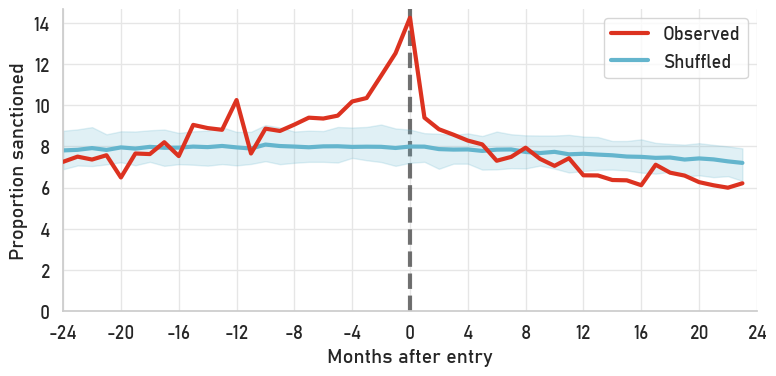

In [28]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
# ...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/shuffle_output_entry_col.png', dpi=300);

Produce grayscale version.

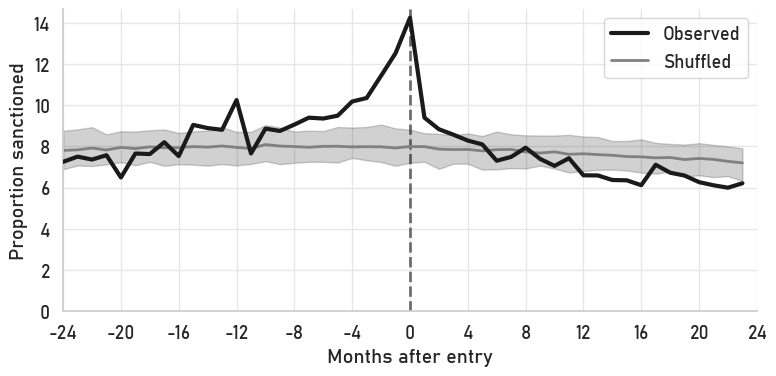

In [29]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
#...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='k', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='0.5', lw=2, label='Shuffled', ls='-', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='k', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=2, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/shuffle_output_entry_bw.png', dpi=300);

Immediate observations:

- The 'counterfactual' line still shows a clear rise and fall around the time of the intervention. What this means is that even randomly assigning AAEs still results in such a pattern - there is nothing 'special' about the true matrix entry point in this respect.
- However, there is a clear spike around the matrix entry point itself - perhaps corresponding to offences that resulted in people being put on the matrix...
- There is a corresponding 'reduction' (or return to normality) after the intervention point, which perhaps indicates effectiveness of the matrix in this short time span.

### Exit points

Now re-plot the data with the exit point as the reference point - i.e. realign the histories with respect to the age at which individuals left the Matrix.

The logic here is that individuals exit the Matrix at a time when their rate of sanction would be expected to be decreasing anyway, so we want to see to what extent the true rate of offending is consistent with what would be expected at those ages.

Here we simply permute the ages at which individuals left the Matrix, regardless of when they entered the Matrix. An alternative approach would be to permute the number of months that individuals spent on the Matrix, in order to test whether duration on the Matrix had any influence. We do not show this - it is left for future work.

First need to restrict the analysis to individuals who actually exited the Matrix - otherwise aligning on exit point does not make sense.

In [30]:
data_exited = data[data['ValidPost'] > 0]

Get the corresponding histories for these individuals.

In [31]:
histories_exited = histories.loc[:, data_exited.index]

Calculate the monthly sanction rates before and after exit.

In [32]:
# Align the histories according to 'PreDurMths'
histories_aligned_exit = align_data_buff(histories_exited, data_exited['PreDurMths'], 24, 24)
# Calculate the means for each row
observed_rates_exit = histories_aligned_exit.mean(axis=1) * 100

Plot these rates over time.

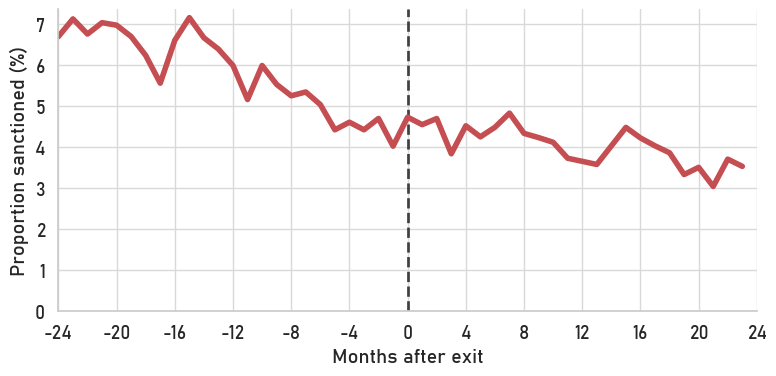

In [33]:
sns.set_style({"grid.color": ".85"})

fig, ax = plt.subplots(figsize=(8, 4))

#Plot those
observed_rates_exit.plot(ylim=(0), color='r', lw=4, ax=ax)
#Add a line at entry point
ax.axvline(0, color ='k', ls='--', lw=2, alpha=0.8, zorder=1)

ax.set_xlim(-24,24)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after exit')
ax.set_ylabel('Proportion sanctioned (%)')
sns.despine()
plt.tight_layout()
plt.savefig('./plots/sanction_rate_pre_post_exit_col.png', dpi=300);

Can observed a consistent decrease over time - rates decrease prior to MAtrix exit, then continue decreasing afterwards.

Now calculate the equivalent rates for the permuted data, generated as described previously.

In [34]:
perm_rates_exit = permuted_rates(histories_exited, data_exited['PreDurMths'], 24, 24, 99)
perm_rates_exit.shape

(99, 48)

Then plot the rates over time.

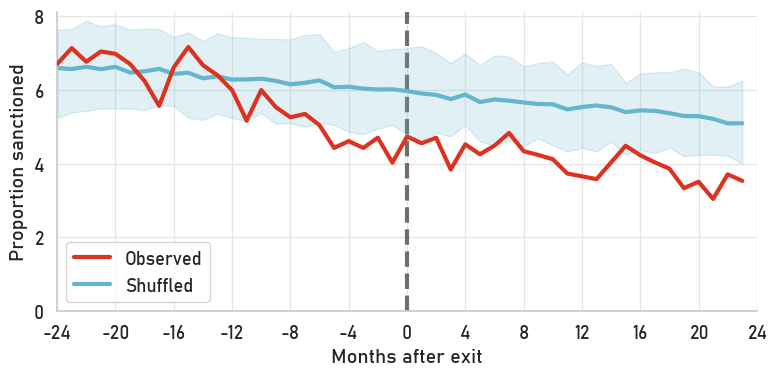

In [35]:
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs_exit = perm_rates_exit * 100
# Calculate the mean across all shuffles
perm_mean_exit = perm_percs_exit.mean(axis=0)
perm_std_exit = perm_percs.std()
perm_sem_exit = perm_percs.sem()
# ...and the quantiles
quantiles_exit = perm_percs_exit.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates_exit.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean_exit.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

#Plot the tube representing the quantiles
ax.fill_between(perm_mean_exit.index, quantiles_exit.loc[0.025, :], quantiles_exit.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after exit')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/shuffle_output_exit_col.png', dpi=300);

Then produce a composite figure showing both entry and exit.

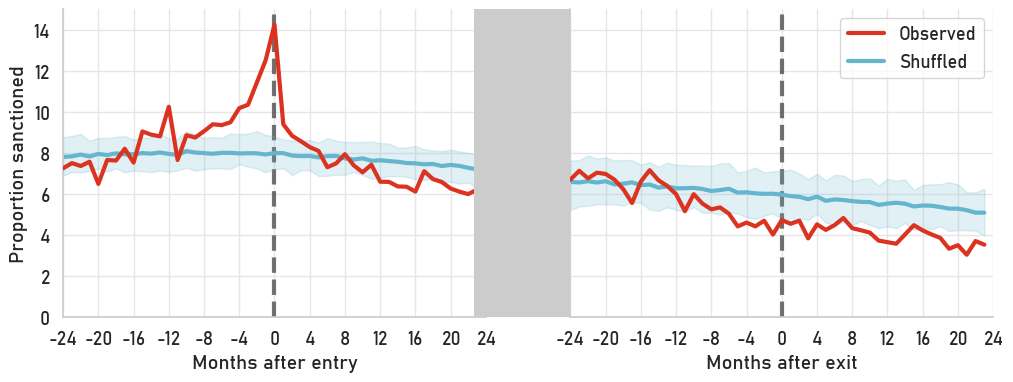

In [36]:
# Initialise overall figure and grid
fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 2, figure=fig, wspace=0.2)

# Initialise left axes
ax = fig.add_subplot(gs[0, 0])

# Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

# Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add line to represent entry point
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0,15)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure
sns.despine()

# Initialise right axes
ax = fig.add_subplot(gs[0, 1])

# Plot the observed rates and the mean shuffled rates as lines
observed_rates_exit.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean_exit.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

# Plot a tube representing the quantiles
ax.fill_between(perm_mean_exit.index, quantiles_exit.loc[0.025, :], quantiles_exit.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0,15)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_yticklabels([])
ax.set_xlabel('Months after exit')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure
sns.despine()

# Add rectangle patch for omitted region
rect = Rectangle(xy=(-24, 0), 
                 width=-11, 
                 height=15, 
                 linewidth=2, 
                 edgecolor='none', 
                 facecolor='0.8', 
                 clip_on=False)
ax.add_patch(rect)

# Save figure
plt.savefig('./plots/shuffle_output_entry_exit_col.png', dpi=300, bbox_inches='tight')